# DL4Baseball

Jonathan Herman jsh2201 

Aryeh Zapinsky

## AtBat-net

### input: A dataset of baseball images
### output: A dataset of images of at-bats

This portion of the pipeline will take a directory of images taken of a baseball game and classify them as at-bats or not.  At this point in the pipeline, we will define <i>at-bat</i> as any frame shot from behind the pitcher showing the batter.  (We will refine this later to strictly a batter's stance.)

The net will borrow the VGG-16 architecture and fine-tune it with a fully connected layer and binary output layer (sigmoid)

In [4]:
import os 
import shutil
import h5py

import matplotlib.pyplot as plt
import time, pandas

import numpy as np

from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, Conv2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras import backend
from keras import optimizers

%matplotlib inline

### Prepare data

##### Get data into this form:

In [6]:
# DL4Baseball
# |-- data
# |   |-- train
# |       |-- AB
# |       |-- not_AB
# |---|-- validation
#         |-- AB
#         |-- not_AB
# ...

In [7]:
# Separate data into at-bats, not at-bats, training and validation
%mkdir -p ./data/train/AB
%mkdir -p ./data/train/not_AB
%mkdir -p ./data/validation/AB
%mkdir -p ./data/validation/not_AB

# Count files 
%find ./AB/ -type f | wc -l         # 3,287
%find ./not_AB/ -type f | wc -l     # 11,111

UsageError: Line magic function `%find` not found.


### Counts:
AB: 3,287

not_AB: 11,111
    
    

### Fill training and validation dirs

##### Using 75/25 train/test split:

./data/train/AB/ -- 2,466 samples

./data/train/not_AB/ -- 8,334 samples

./data/validation/AB/ -- 821 samples

./data/validation/not_AB/ -- 2,777 samples

We will augment the data to have even more samples.

In [10]:
def prepare_dir(label, dest, size):
    '''Move SIZE samples of LABEL imgs into DEST'''
    source = './' + label + '/'
    dest = './data/' + dest + '/' + label + '/' 
    # random selection of SIZE of LABEL
    train_sample = np.random.choice(os.listdir(source), size=size, replace=False)
    
    for fp in train_sample:
        shutil.move(source + fp, dest + fp)        

# Prepare training sets according to sizes above
print('Preparing at-bats training set...')
prepare_dir('AB', dest='train', size=2466)
print('Preparing non-at-bats training set...')
prepare_dir('not_AB', dest='train', size=8334)

# Prepare validation sets with 1k samples
print('Preparing at-bats validation set...')
prepare_dir('AB', dest='validation', size=821)
print('Preparing non-at-bats validation set...')
prepare_dir('not_AB', dest='validation', size=2777)

Preparing at-bats training set...
Preparing non-at-bats training set...
Preparing at-bats validation set...
Preparing non-at-bats validation set...


### Augment data

In [5]:
# Image info
train_data_dir = './data/train/'
validation_data_dir = './data/validation/'
img_width, img_height = (300, 300)

# Calculate steps per epoch
nb_train_samples = 10800
nb_validation_samples = 3598
batch_size = 32
steps_per_epoch_train = nb_train_samples / batch_size
steps_per_epoch_val = nb_validation_samples / batch_size

In [6]:
# Data augmentation for training
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,)

# Data augmentation for testing (only scaling)
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        batch_size=batch_size,
        class_mode='binary')

Found 10798 images belonging to 2 classes.
Found 3598 images belonging to 2 classes.


### Build VGG-16 architecture

In [7]:
def build_vgg16(framework='tf'):
    global img_width, img_height # might not need this

    if framework == 'th':
        # build the VGG16 network in Theano weight ordering mode
        backend.set_image_dim_ordering('th')
    else:
        # build the VGG16 network in Tensorflow weight ordering mode
        backend.set_image_dim_ordering('tf')
        
    model = Sequential()
    if framework == 'th':
        model.add(ZeroPadding2D((1, 1), input_shape=(3, img_width, img_height)))
    else:
        model.add(ZeroPadding2D((1, 1), input_shape=(img_width, img_height, 3)))
        
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(64, (3, 3), activation='relu', name='conv1_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(128, (3, 3), activation='relu', name='conv2_2'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(256, (3, 3), activation='relu', name='conv3_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv4_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))

    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_1'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_2'))
    model.add(ZeroPadding2D((1, 1)))
    model.add(Conv2D(512, (3, 3), activation='relu', name='conv5_3'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    return model

In [8]:
# Instantiate and load weights
weights_path = './vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5'
vgg_16 = build_vgg16('tf')
vgg_16.load_weights(weights_path)

vgg_16.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_1 (ZeroPaddin (None, 302, 302, 3)       0         
_________________________________________________________________
conv1_1 (Conv2D)             (None, 300, 300, 64)      1792      
_________________________________________________________________
zero_padding2d_2 (ZeroPaddin (None, 302, 302, 64)      0         
_________________________________________________________________
conv1_2 (Conv2D)             (None, 300, 300, 64)      36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 150, 150, 64)      0         
_________________________________________________________________
zero_padding2d_3 (ZeroPaddin (None, 152, 152, 64)      0         
_________________________________________________________________
conv2_1 (Conv2D)             (None, 150, 150, 128)     73856     
__________

### Add fully connected layer followed by sigmoid output on top

In [9]:
top_model = Sequential()
top_model.add(Flatten(input_shape=vgg_16.output_shape[1:]))
top_model.add(Dense(256, activation='relu'))
top_model.add(Dropout(0.5))
top_model.add(Dense(1, activation='sigmoid'))

print(top_model.summary())

# Add it to vgg model
vgg_16.add(top_model)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 41472)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 256)               10617088  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 257       
Total params: 10,617,345
Trainable params: 10,617,345
Non-trainable params: 0
_________________________________________________________________
None


### Freeze lower layers and train top

In [10]:
# Freeze first 25 layers
for layer in vgg_16.layers[:25]:
    layer.trainable = False

# compile the model with a SGD/momentum optimizer
# and a very slow learning rate.
vgg_16.compile(loss='binary_crossentropy',
              optimizer=optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])




In [ ]:
# Create directories for bookkeeping
% mkdir ./models
% mkdir ./history

In [26]:
# Checkpoint progress
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg_16.best.hdf5', 
                        monitor='val_acc', 
                        verbose=0, 
                        save_best_only=True, 
                        save_weights_only=False, 
                        mode='auto', period=1)

# Train
nb_epoch = 5
fit_model = vgg_16.fit_generator(train_generator, 
                initial_epoch=0, 
                verbose=1, 
                validation_data=validation_generator, 
                steps_per_epoch=steps_per_epoch_train, 
                epochs=nb_epoch, 
                callbacks=[tensorboard_callback, checkpoint_callback],
                validation_steps=steps_per_epoch_val)
                                                                                                                                   
pandas.DataFrame(fit_model.history).to_csv("./history/fine_tune.csv")

Epoch 1/5
338/337 [==============================] - 336s 995ms/step - loss: 0.0563 - acc: 0.9775 - val_loss: 0.0489 - val_acc: 0.9778
Epoch 2/5
338/337 [==============================] - 329s 974ms/step - loss: 0.0513 - acc: 0.9801 - val_loss: 0.0483 - val_acc: 0.9780
Epoch 3/5
338/337 [==============================] - 329s 973ms/step - loss: 0.0450 - acc: 0.9823 - val_loss: 0.0418 - val_acc: 0.9830
Epoch 4/5
338/337 [==============================] - 329s 973ms/step - loss: 0.0422 - acc: 0.9855 - val_loss: 0.0374 - val_acc: 0.9914
Epoch 5/5
338/337 [==============================] - 328s 971ms/step - loss: 0.0401 - acc: 0.9859 - val_loss: 0.0360 - val_acc: 0.9919


In [12]:
vgg_16 = load_model('./models/vgg_16.best.hdf5')

# Checkpoint progress
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg_16.best.hdf5', 
                        monitor='val_acc', 
                        verbose=0, 
                        save_best_only=True, 
                        save_weights_only=False, 
                        mode='auto', period=1)

# Train
nb_epoch = 7
fit_model = vgg_16.fit_generator(train_generator, 
                initial_epoch=5, 
                verbose=1, 
                validation_data=validation_generator, 
                steps_per_epoch=steps_per_epoch_train, 
                epochs=nb_epoch, 
                callbacks=[tensorboard_callback, checkpoint_callback],
                validation_steps=steps_per_epoch_val)
                                                                                                                                   
pandas.DataFrame(fit_model.history).to_csv("./history/fine_tune.csv")

Epoch 6/7
338/337 [==============================] - 825s 2s/step - loss: 0.0371 - acc: 0.9879 - val_loss: 0.0387 - val_acc: 0.9864
Epoch 7/7
338/337 [==============================] - 325s 961ms/step - loss: 0.0369 - acc: 0.9884 - val_loss: 0.0328 - val_acc: 0.9928


### Unfreeze and train entire network

In [16]:
# Load in fine-tuned model
vgg_16 = load_model('./models/vgg_16.best.hdf5')

In [17]:
# Unfreeze first 25 layers
for layer in vgg_16.layers[:25]:
    layer.trainable = True

In [18]:
# Checkpoint progress
tensorboard_callback = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)
checkpoint_callback = ModelCheckpoint('./models/vgg_16.best.hdf5', 
                        monitor='val_acc', 
                        verbose=0, 
                        save_best_only=True, 
                        save_weights_only=False, 
                        mode='auto', period=1)

In [19]:
# Train
nb_epoch = 11
vgg_16_fit = vgg_16.fit_generator(train_generator, 
                initial_epoch=0, 
                verbose=1, 
                validation_data=validation_generator, 
                steps_per_epoch=steps_per_epoch_train, 
                epochs=nb_epoch, 
                callbacks=[tensorboard_callback, checkpoint_callback],
                validation_steps=steps_per_epoch_val)
                                                                                                                                   
pandas.DataFrame(vgg_16_fit.history).to_csv("./history/vgg_16_entire.csv")

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/11
338/337 [==============================] - 334s 988ms/step - loss: 0.0357 - acc: 0.9892 - val_loss: 0.0390 - val_acc: 0.9875
Epoch 2/11
338/337 [==============================] - 324s 959ms/step - loss: 0.0321 - acc: 0.9919 - val_loss: 0.0317 - val_acc: 0.9936
Epoch 3/11
338/337 [==============================] - 320s 947ms/step - loss: 0.0329 - acc: 0.9899 - val_loss: 0.0344 - val_acc: 0.9928
Epoch 4/11
338/337 [==============================] - 320s 945ms/step - loss: 0.0303 - acc: 0.9913 - val_loss: 0.0304 - val_acc: 0.9936
Epoch 5/11
338/337 [==============================] - 321s 948ms/step - loss: 0.0301 - acc: 0.9913 - val_loss: 0.0303 - val_acc: 0.9939
Epoch 6/11
338/337 [==============================] - 321s 951ms/step - loss: 0.0284 - acc: 0.9925 - val_loss: 0.0309 - val_acc: 0.9936
Epoch 7/11
338/337 [==============================] - 320s 946ms/step - loss: 0.0288 - acc: 0.9922 - val_loss: 0.0286 - val_acc: 0.9931
Epoch 8/11
338/337 [============================

### Evaluate accuracy 

The fully trained net gets a validation accruracy as high as <strong>94.4%</strong>! Below are some sample classifications.

In [7]:
vgg_16_fit = load_model('./models/vgg_16.best.hdf5')

X_test, y_test = next(validation_generator)
predictions = vgg_16_fit.predict_classes(X_test, batch_size=32, verbose=0)

/usr/local/lib/python3.5/dist-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


### Show sample outputs

In [8]:
nb_classes = 2
class_name = {
    0: 'AB',
    1: 'not_AB',
}

In [9]:
def show_sample(X, y, prediction=-1):
    im = X
    plt.imshow(im)
    plt.title("Class = %s, Predict = %s" % (class_name[y], class_name[prediction]))

    plt.axis('on')
    plt.show()

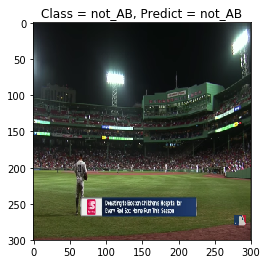

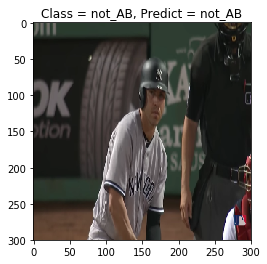

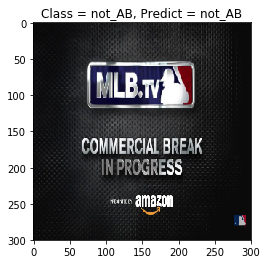

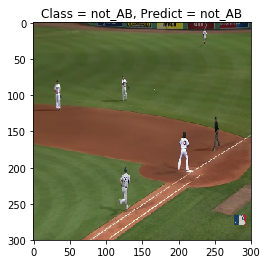

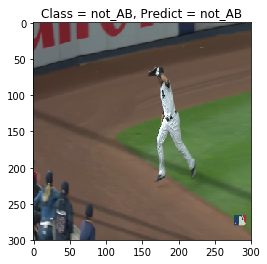

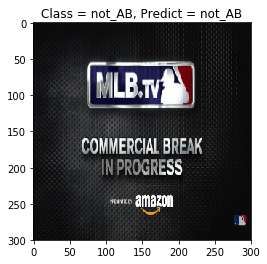

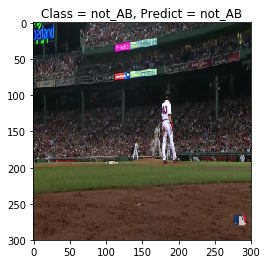

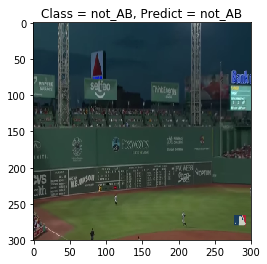

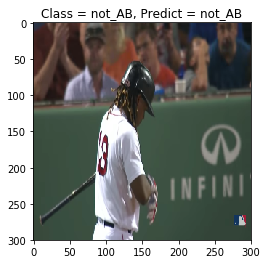

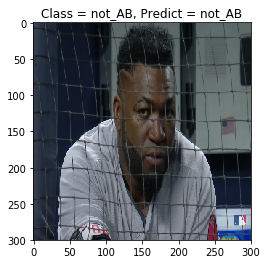

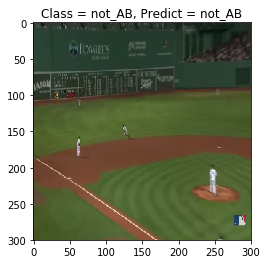

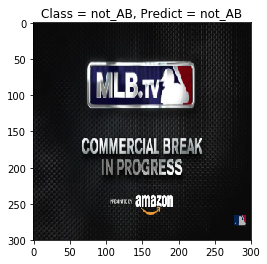

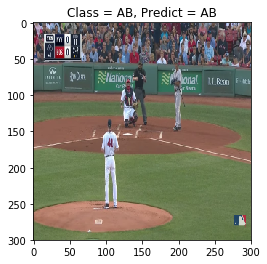

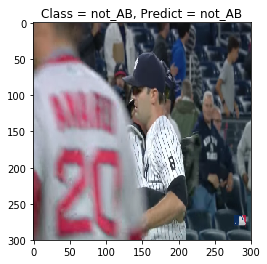

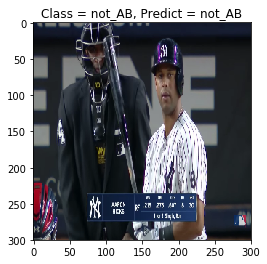

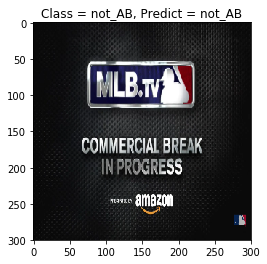

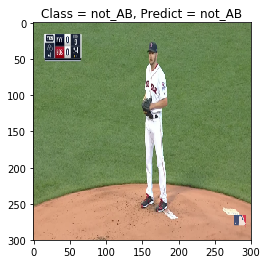

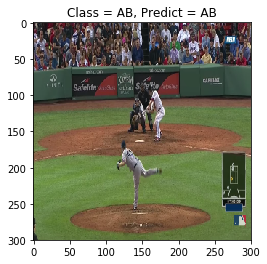

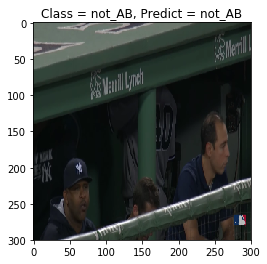

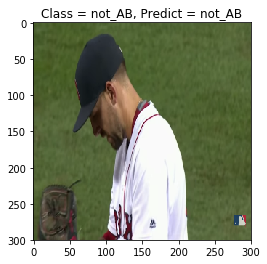

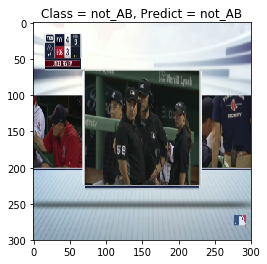

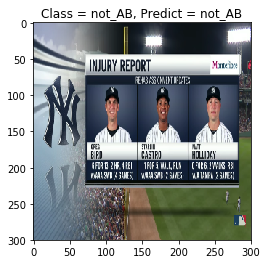

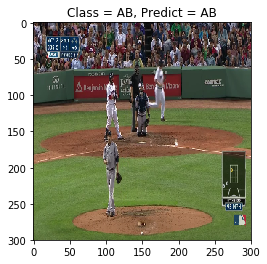

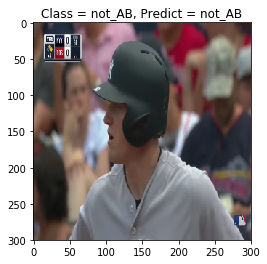

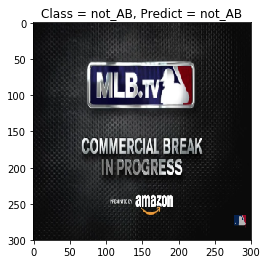

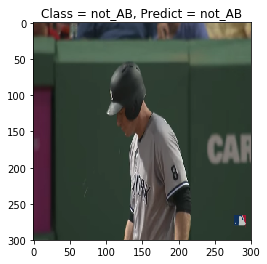

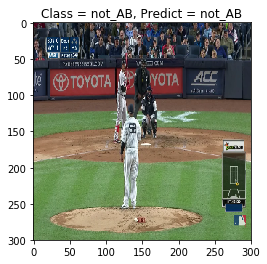

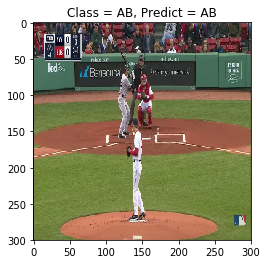

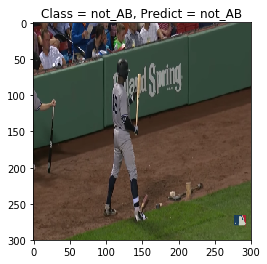

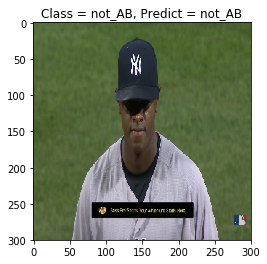

In [12]:
# Display some images 
for i in range(30):
    show_sample(X_test[i, :, :, :], y_test[i], prediction=predictions[i, 0])

# Summary:

The at-bat portion of the pipeline works as planned.  The next step is to refine the classification so that we can isolate pictures of batter's in their stance.  We will label the AB data as batting_stance and non_batting_stance.  We will pass this through a similar CNN for classification.  The resulting pipeline (AB CNN + batting_stance CNN) will be able to take a stream of game footage and isolate batting stances.